=== Bootstrap Consistency Training Experiment ===

1. SIMULATED DATA EXPERIMENT
----------------------------------------
Testing Standard Training...
Testing Bootstrap Consistency Training...
Epoch 0: Loss=0.579, Pred=0.577, Consistency=0.010
Epoch 10: Loss=0.213, Pred=0.209, Consistency=0.024
Epoch 20: Loss=0.131, Pred=0.125, Consistency=0.027
Epoch 0: Loss=0.607, Pred=0.605, Consistency=0.009
Epoch 10: Loss=0.201, Pred=0.196, Consistency=0.026
Epoch 20: Loss=0.115, Pred=0.110, Consistency=0.025
Epoch 0: Loss=0.572, Pred=0.570, Consistency=0.011
Epoch 10: Loss=0.206, Pred=0.201, Consistency=0.024
Epoch 20: Loss=0.127, Pred=0.122, Consistency=0.027
Epoch 0: Loss=0.617, Pred=0.615, Consistency=0.011
Epoch 10: Loss=0.224, Pred=0.219, Consistency=0.024
Epoch 20: Loss=0.141, Pred=0.135, Consistency=0.026
Epoch 0: Loss=0.604, Pred=0.602, Consistency=0.009
Epoch 10: Loss=0.230, Pred=0.225, Consistency=0.024
Epoch 20: Loss=0.165, Pred=0.160, Consistency=0.025
Epoch 0: Loss=0.635, Pred=0.633, 

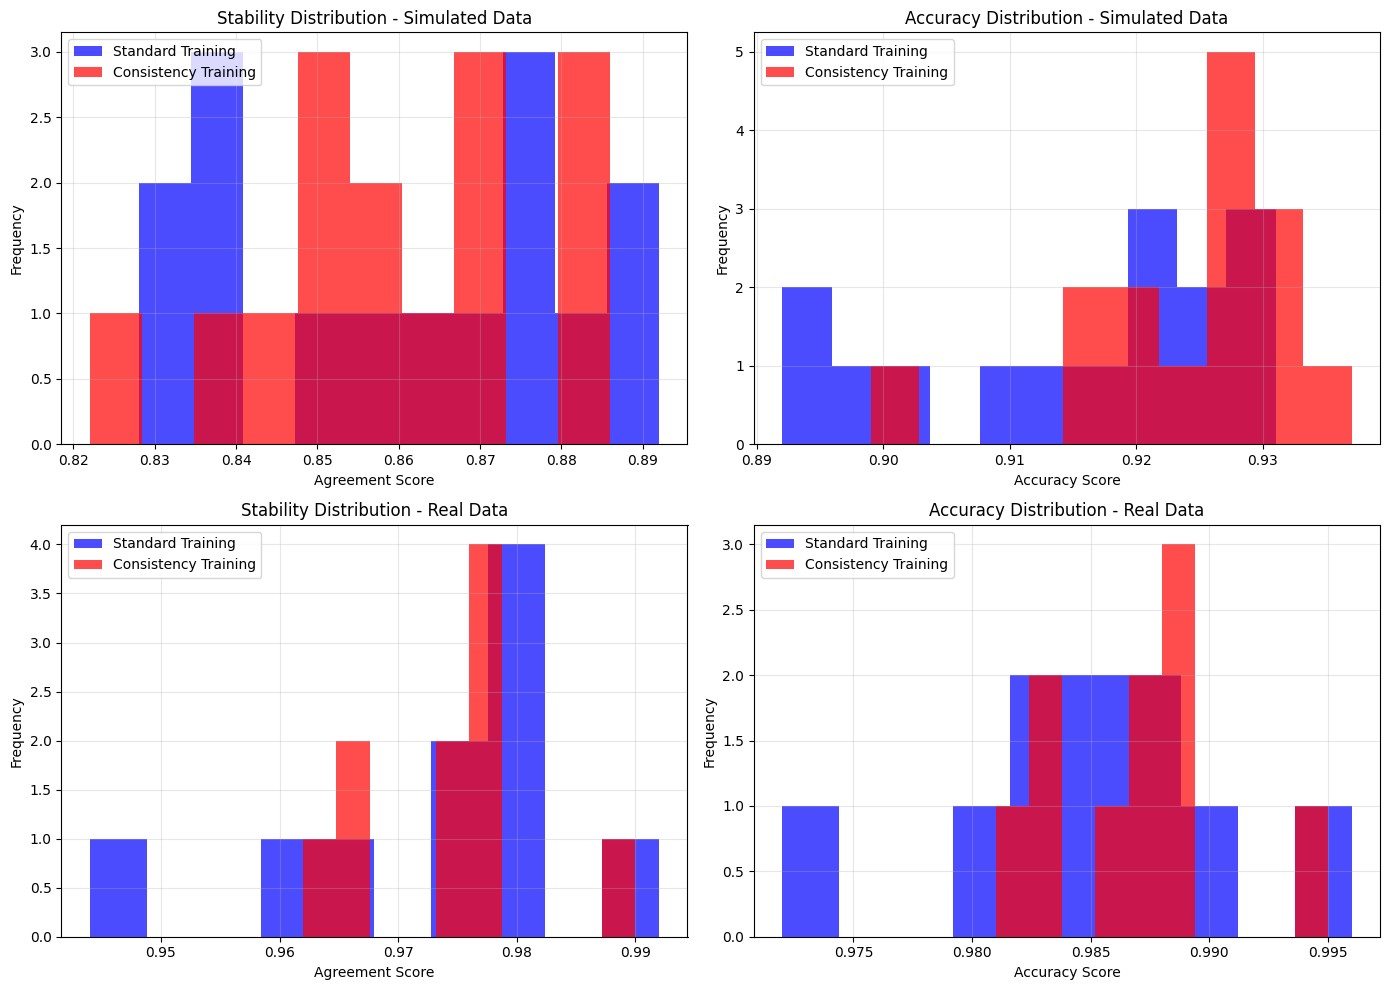

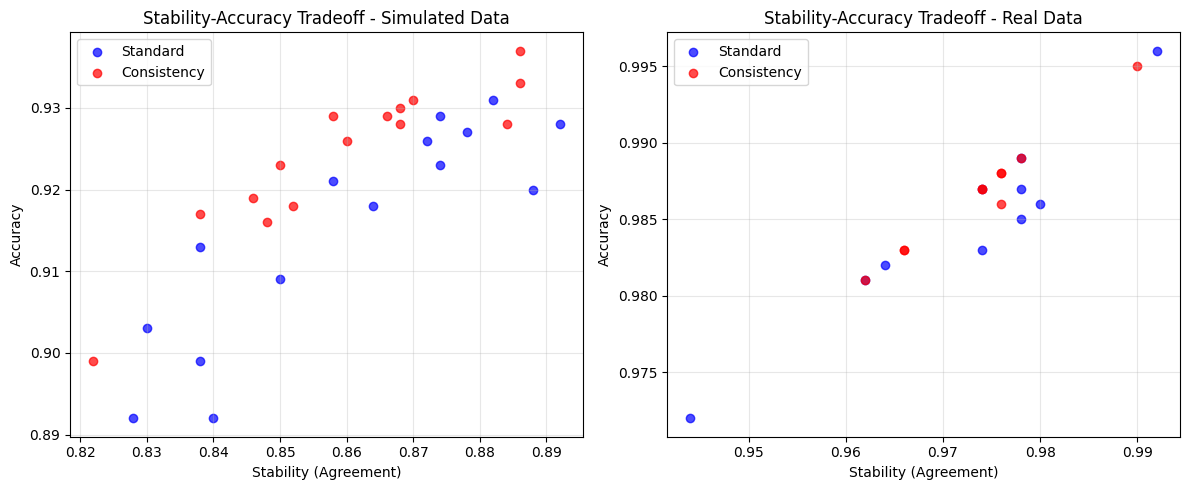

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

def bootstrap_consistency_loss(model, x, y, n_bootstrap=5, lambda_consistency=0.1):
    """
    Improved bootstrap consistency loss with multiple samples

    Args:
        model: PyTorch model
        x: input batch [batch_size, features]
        y: labels [batch_size]
        n_bootstrap: number of bootstrap samples to create
        lambda_consistency: weight for consistency penalty

    Returns:
        average_loss: combined prediction loss + consistency penalty
    """
    batch_size = x.shape[0]

    # Create multiple bootstrap samples
    bootstrap_indices = []
    for i in range(n_bootstrap):
        indices = torch.randint(0, batch_size, (batch_size,), device=x.device)
        bootstrap_indices.append(indices)

    # Get predictions for each bootstrap sample
    predictions = []
    prediction_losses = []

    for indices in bootstrap_indices:
        x_boot, y_boot = x[indices], y[indices]
        pred = model(x_boot)
        predictions.append(pred)
        loss = F.cross_entropy(pred, y_boot)
        prediction_losses.append(loss)

    # Average prediction loss
    avg_prediction_loss = torch.mean(torch.stack(prediction_losses))

    # Consistency penalty: penalize disagreement on overlapping examples
    consistency_penalty = 0.0
    n_comparisons = 0

    for i in range(n_bootstrap):
        for j in range(i + 1, n_bootstrap):
            # Find overlapping examples between bootstrap samples i and j
            indices_i = bootstrap_indices[i]
            indices_j = bootstrap_indices[j]

            # Create overlap mask: which positions in sample i correspond to same original examples as in sample j
            overlap_mask = indices_i.unsqueeze(1) == indices_j.unsqueeze(0)  # [batch_size, batch_size]

            if overlap_mask.any():
                # For each overlapping pair, compute disagreement
                for orig_idx in range(batch_size):
                    # Find positions in sample i that contain original example orig_idx
                    pos_i = (indices_i == orig_idx).nonzero(as_tuple=True)[0]
                    # Find positions in sample j that contain original example orig_idx
                    pos_j = (indices_j == orig_idx).nonzero(as_tuple=True)[0]

                    if len(pos_i) > 0 and len(pos_j) > 0:
                        # Compare predictions for the same original example
                        pred_i = predictions[i][pos_i[0]]  # Take first occurrence
                        pred_j = predictions[j][pos_j[0]]  # Take first occurrence

                        # MSE between softmax probabilities
                        prob_i = F.softmax(pred_i, dim=0)
                        prob_j = F.softmax(pred_j, dim=0)
                        disagreement = F.mse_loss(prob_i, prob_j)
                        consistency_penalty += disagreement
                        n_comparisons += 1

    # Average consistency penalty
    if n_comparisons > 0:
        consistency_penalty = consistency_penalty / n_comparisons
    else:
        consistency_penalty = torch.tensor(0.0, device=x.device)

    # Combined loss
    total_loss = avg_prediction_loss + lambda_consistency * consistency_penalty

    return total_loss, avg_prediction_loss, consistency_penalty

def train_model_with_consistency(model, train_loader, epochs=50, lambda_consistency=0.1, lr=0.001):
    """Train model with bootstrap consistency regularization"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    losses = []
    prediction_losses = []
    consistency_penalties = []

    for epoch in range(epochs):
        epoch_losses = []
        epoch_pred_losses = []
        epoch_consistency = []

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()

            total_loss, pred_loss, consistency_penalty = bootstrap_consistency_loss(
                model, batch_x, batch_y, n_bootstrap=4, lambda_consistency=lambda_consistency
            )

            total_loss.backward()
            optimizer.step()

            epoch_losses.append(total_loss.item())
            epoch_pred_losses.append(pred_loss.item())
            epoch_consistency.append(consistency_penalty.item())

        losses.append(np.mean(epoch_losses))
        prediction_losses.append(np.mean(epoch_pred_losses))
        consistency_penalties.append(np.mean(epoch_consistency))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss={losses[-1]:.3f}, Pred={prediction_losses[-1]:.3f}, Consistency={consistency_penalties[-1]:.3f}")

    return losses, prediction_losses, consistency_penalties

def measure_model_stability(model_class, train_fn, X, y, n_trials=10, lambda_consistency=0.0):
    """Measure stability using Turney's approach for neural networks"""
    agreements = []
    accuracies = []

    # Convert to torch tensors
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_tensor = torch.FloatTensor(X_scaled)
    y_tensor = torch.LongTensor(y)

    for trial in range(n_trials):
        # Split data randomly
        X1, X2, y1, y2 = train_test_split(X_scaled, y, test_size=0.5, random_state=trial)

        # Convert to tensors and create data loaders
        X1_tensor = torch.FloatTensor(X1)
        y1_tensor = torch.LongTensor(y1)
        X2_tensor = torch.FloatTensor(X2)
        y2_tensor = torch.LongTensor(y2)

        train_loader1 = DataLoader(TensorDataset(X1_tensor, y1_tensor), batch_size=32, shuffle=True)
        train_loader2 = DataLoader(TensorDataset(X2_tensor, y2_tensor), batch_size=32, shuffle=True)

        # Train two models
        model1 = model_class(X.shape[1])
        model2 = model_class(X.shape[1])

        train_fn(model1, train_loader1, epochs=30, lambda_consistency=lambda_consistency, lr=0.01)
        train_fn(model2, train_loader2, epochs=30, lambda_consistency=lambda_consistency, lr=0.01)

        # Test agreement on bootstrap sample from full dataset
        test_indices = np.random.choice(len(X), size=min(500, len(X)), replace=True)
        X_test = X_tensor[test_indices]
        y_test = y_tensor[test_indices]

        model1.eval()
        model2.eval()
        with torch.no_grad():
            pred1 = model1(X_test).argmax(dim=1)
            pred2 = model2(X_test).argmax(dim=1)

            agreement = (pred1 == pred2).float().mean().item()
            agreements.append(agreement)

            # Accuracy
            acc1 = (pred1 == y_test).float().mean().item()
            acc2 = (pred2 == y_test).float().mean().item()
            avg_accuracy = (acc1 + acc2) / 2
            accuracies.append(avg_accuracy)

    return np.array(agreements), np.array(accuracies)

def run_consistency_experiment():
    print("=== Bootstrap Consistency Training Experiment ===\n")

    # Generate data
    print("1. SIMULATED DATA EXPERIMENT")
    print("-" * 40)
    X_sim, y_sim = make_classification(n_samples=1000, n_features=20,
                                       n_informative=12, n_redundant=4,
                                       flip_y=0.05, class_sep=0.8, random_state=42)

    # Standard training function
    def standard_training(model, train_loader, epochs=50, lambda_consistency=0.0, lr=0.001):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        model.train()
        for epoch in range(epochs):
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                pred = model(batch_x)
                loss = F.cross_entropy(pred, batch_y)
                loss.backward()
                optimizer.step()

    # Test Standard Training
    print("Testing Standard Training...")
    stability_standard, accuracy_standard = measure_model_stability(
        SimpleNN, standard_training, X_sim, y_sim, n_trials=15, lambda_consistency=0.0)

    # Test Consistency Training
    print("Testing Bootstrap Consistency Training...")
    stability_consistent, accuracy_consistent = measure_model_stability(
        SimpleNN, train_model_with_consistency, X_sim, y_sim, n_trials=15, lambda_consistency=0.2)

    print(f"\nStandard Training:")
    print(f"  Stability: {stability_standard.mean():.3f} ± {stability_standard.std():.3f}")
    print(f"  Accuracy:  {accuracy_standard.mean():.3f} ± {accuracy_standard.std():.3f}")

    print(f"\nConsistency Training:")
    print(f"  Stability: {stability_consistent.mean():.3f} ± {stability_consistent.std():.3f}")
    print(f"  Accuracy:  {accuracy_consistent.mean():.3f} ± {accuracy_consistent.std():.3f}")

    print(f"\nImprovement in Stability: {(stability_consistent.mean() - stability_standard.mean()):.3f}")
    print(f"Change in Accuracy: {(accuracy_consistent.mean() - accuracy_standard.mean()):.3f}")

    # Real Data Test
    print("\n" + "="*50)
    print("2. REAL DATA EXPERIMENT (Breast Cancer)")
    print("-" * 40)
    X_real, y_real = load_breast_cancer(return_X_y=True)

    stability_standard_real, accuracy_standard_real = measure_model_stability(
        SimpleNN, standard_training, X_real, y_real, n_trials=10, lambda_consistency=0.0)

    stability_consistent_real, accuracy_consistent_real = measure_model_stability(
        SimpleNN, train_model_with_consistency, X_real, y_real, n_trials=10, lambda_consistency=0.15)

    print(f"\nStandard Training:")
    print(f"  Stability: {stability_standard_real.mean():.3f} ± {stability_standard_real.std():.3f}")
    print(f"  Accuracy:  {accuracy_standard_real.mean():.3f} ± {accuracy_standard_real.std():.3f}")

    print(f"\nConsistency Training:")
    print(f"  Stability: {stability_consistent_real.mean():.3f} ± {stability_consistent_real.std():.3f}")
    print(f"  Accuracy:  {accuracy_consistent_real.mean():.3f} ± {accuracy_consistent_real.std():.3f}")

    print(f"\nImprovement in Stability: {(stability_consistent_real.mean() - stability_standard_real.mean()):.3f}")
    print(f"Change in Accuracy: {(accuracy_consistent_real.mean() - accuracy_standard_real.mean()):.3f}")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Simulated Data
    axes[0,0].hist(stability_standard, alpha=0.7, label='Standard Training', bins=10, color='blue')
    axes[0,0].hist(stability_consistent, alpha=0.7, label='Consistency Training', bins=10, color='red')
    axes[0,0].set_xlabel('Agreement Score')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Stability Distribution - Simulated Data')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    axes[0,1].hist(accuracy_standard, alpha=0.7, label='Standard Training', bins=10, color='blue')
    axes[0,1].hist(accuracy_consistent, alpha=0.7, label='Consistency Training', bins=10, color='red')
    axes[0,1].set_xlabel('Accuracy Score')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Accuracy Distribution - Simulated Data')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Real Data
    axes[1,0].hist(stability_standard_real, alpha=0.7, label='Standard Training', bins=10, color='blue')
    axes[1,0].hist(stability_consistent_real, alpha=0.7, label='Consistency Training', bins=10, color='red')
    axes[1,0].set_xlabel('Agreement Score')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Stability Distribution - Real Data')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    axes[1,1].hist(accuracy_standard_real, alpha=0.7, label='Standard Training', bins=10, color='blue')
    axes[1,1].hist(accuracy_consistent_real, alpha=0.7, label='Consistency Training', bins=10, color='red')
    axes[1,1].set_xlabel('Accuracy Score')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Accuracy Distribution - Real Data')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Stability vs Accuracy scatter
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(stability_standard, accuracy_standard, alpha=0.7, label='Standard', color='blue')
    plt.scatter(stability_consistent, accuracy_consistent, alpha=0.7, label='Consistency', color='red')
    plt.xlabel('Stability (Agreement)')
    plt.ylabel('Accuracy')
    plt.title('Stability-Accuracy Tradeoff - Simulated Data')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.scatter(stability_standard_real, accuracy_standard_real, alpha=0.7, label='Standard', color='blue')
    plt.scatter(stability_consistent_real, accuracy_consistent_real, alpha=0.7, label='Consistency', color='red')
    plt.xlabel('Stability (Agreement)')
    plt.ylabel('Accuracy')
    plt.title('Stability-Accuracy Tradeoff - Real Data')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_consistency_experiment()

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

def bootstrap_consistency_loss(model, x, y, n_bootstrap=5, lambda_consistency=0.1):
    """
    Bootstrap consistency loss with configurable number of samples
    """
    batch_size = x.shape[0]

    # Create multiple bootstrap samples
    bootstrap_indices = []
    for i in range(n_bootstrap):
        indices = torch.randint(0, batch_size, (batch_size,), device=x.device)
        bootstrap_indices.append(indices)

    # Get predictions for each bootstrap sample
    predictions = []
    prediction_losses = []

    for indices in bootstrap_indices:
        x_boot, y_boot = x[indices], y[indices]
        pred = model(x_boot)
        predictions.append(pred)
        loss = F.cross_entropy(pred, y_boot)
        prediction_losses.append(loss)

    # Average prediction loss
    avg_prediction_loss = torch.mean(torch.stack(prediction_losses))

    # Consistency penalty: penalize disagreement on overlapping examples
    consistency_penalty = 0.0
    n_comparisons = 0

    for i in range(n_bootstrap):
        for j in range(i + 1, n_bootstrap):
            indices_i = bootstrap_indices[i]
            indices_j = bootstrap_indices[j]

            # Find overlapping examples efficiently
            for orig_idx in range(batch_size):
                pos_i = (indices_i == orig_idx).nonzero(as_tuple=True)[0]
                pos_j = (indices_j == orig_idx).nonzero(as_tuple=True)[0]

                if len(pos_i) > 0 and len(pos_j) > 0:
                    # Compare predictions for the same original example
                    pred_i = predictions[i][pos_i[0]]
                    pred_j = predictions[j][pos_j[0]]

                    # MSE between softmax probabilities
                    prob_i = F.softmax(pred_i, dim=0)
                    prob_j = F.softmax(pred_j, dim=0)
                    disagreement = F.mse_loss(prob_i, prob_j)
                    consistency_penalty += disagreement
                    n_comparisons += 1

    # Average consistency penalty
    if n_comparisons > 0:
        consistency_penalty = consistency_penalty / n_comparisons
    else:
        consistency_penalty = torch.tensor(0.0, device=x.device)

    # Combined loss
    total_loss = avg_prediction_loss + lambda_consistency * consistency_penalty
    return total_loss

def create_challenging_datasets():
    """
    Create datasets where bootstrap consistency training should be most beneficial
    """
    datasets = {}

    # 1. High Noise Dataset
    X1, y1 = make_classification(
        n_samples=600, n_features=15, n_informative=8, n_redundant=3,
        flip_y=0.15, class_sep=0.6, random_state=42
    )
    datasets['High Noise'] = (X1, y1, "15% label noise, low class separation")

    # 2. Small Sample Dataset
    X2, y2 = make_classification(
        n_samples=200, n_features=12, n_informative=8, n_redundant=2,
        flip_y=0.05, class_sep=0.8, random_state=43
    )
    datasets['Small Sample'] = (X2, y2, "Only 200 samples, bootstrap variance high")

    # 3. High Dimensional with Irrelevant Features
    X3, y3 = make_classification(
        n_samples=800, n_features=50, n_informative=8, n_redundant=5,
        flip_y=0.08, class_sep=0.7, random_state=44
    )
    datasets['High Dimensional'] = (X3, y3, "50 features, only 8 informative")

    # 4. Imbalanced Classes
    X4, y4 = make_classification(
        n_samples=700, n_features=15, n_informative=10, n_redundant=3,
        weights=[0.8, 0.2], flip_y=0.06, class_sep=0.75, random_state=45
    )
    datasets['Imbalanced'] = (X4, y4, "80-20 class imbalance")

    # 5. Multiple Valid Patterns (overlapping clusters)
    X5, y5 = make_classification(
        n_samples=600, n_features=20, n_informative=12, n_redundant=4,
        n_clusters_per_class=3, flip_y=0.07, class_sep=0.6, random_state=46
    )
    datasets['Multi-Pattern'] = (X5, y5, "3 clusters per class, multiple valid solutions")

    # 6. Real-world comparison
    X6, y6 = load_breast_cancer(return_X_y=True)
    datasets['Breast Cancer'] = (X6, y6, "Real medical data, 30 features")

    return datasets

def train_model_with_consistency(model, train_loader, epochs=40, n_bootstrap=5, lambda_consistency=0.1, lr=0.001):
    """Train model with bootstrap consistency regularization"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            total_loss = bootstrap_consistency_loss(
                model, batch_x, batch_y, n_bootstrap=n_bootstrap, lambda_consistency=lambda_consistency
            )
            total_loss.backward()
            optimizer.step()

def standard_training(model, train_loader, epochs=40, n_bootstrap=5, lambda_consistency=0.0, lr=0.001):
    """Standard training without consistency regularization"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            pred = model(batch_x)
            loss = F.cross_entropy(pred, batch_y)
            loss.backward()
            optimizer.step()

def measure_model_stability(model_class, train_fn, X, y, n_trials=12, **train_kwargs):
    """Measure stability using Turney's approach"""
    agreements = []
    accuracies = []

    # Convert to torch tensors
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_tensor = torch.FloatTensor(X_scaled)
    y_tensor = torch.LongTensor(y)

    for trial in range(n_trials):
        # Split data randomly
        X1, X2, y1, y2 = train_test_split(X_scaled, y, test_size=0.5, random_state=trial)

        # Convert to tensors and create data loaders
        X1_tensor = torch.FloatTensor(X1)
        y1_tensor = torch.LongTensor(y1)
        X2_tensor = torch.FloatTensor(X2)
        y2_tensor = torch.LongTensor(y2)

        train_loader1 = DataLoader(TensorDataset(X1_tensor, y1_tensor), batch_size=32, shuffle=True)
        train_loader2 = DataLoader(TensorDataset(X2_tensor, y2_tensor), batch_size=32, shuffle=True)

        # Train two models
        model1 = model_class(X.shape[1])
        model2 = model_class(X.shape[1])

        train_fn(model1, train_loader1, **train_kwargs)
        train_fn(model2, train_loader2, **train_kwargs)

        # Test agreement on bootstrap sample from full dataset
        test_indices = np.random.choice(len(X), size=min(400, len(X)), replace=True)
        X_test = X_tensor[test_indices]
        y_test = y_tensor[test_indices]

        model1.eval()
        model2.eval()
        with torch.no_grad():
            pred1 = model1(X_test).argmax(dim=1)
            pred2 = model2(X_test).argmax(dim=1)

            agreement = (pred1 == pred2).float().mean().item()
            agreements.append(agreement)

            # Accuracy
            acc1 = (pred1 == y_test).float().mean().item()
            acc2 = (pred2 == y_test).float().mean().item()
            avg_accuracy = (acc1 + acc2) / 2
            accuracies.append(avg_accuracy)

    return np.array(agreements), np.array(accuracies)

def run_comprehensive_experiment():
    """Run bootstrap consistency experiment across multiple challenging datasets"""
    print("=== Comprehensive Bootstrap Consistency Training Experiment ===\n")

    # Create challenging datasets
    datasets = create_challenging_datasets()

    # Parameters for consistency training
    consistency_params = {
        'epochs': 35,
        'n_bootstrap': 5,  # Fixed: consistent number of bootstrap samples
        'lambda_consistency': 0.15,
        'lr': 0.008
    }

    standard_params = {
        'epochs': 35,
        'n_bootstrap': 5,  # Not used but keeps interface consistent
        'lambda_consistency': 0.0,
        'lr': 0.008
    }

    results = []

    for dataset_name, (X, y, description) in datasets.items():
        print(f"Testing on {dataset_name} dataset...")
        print(f"  Description: {description}")
        print(f"  Shape: {X.shape}, Classes: {len(np.unique(y))}")

        # Test Standard Training
        stability_std, accuracy_std = measure_model_stability(
            SimpleNN, standard_training, X, y, n_trials=10, **standard_params)

        # Test Consistency Training
        stability_con, accuracy_con = measure_model_stability(
            SimpleNN, train_model_with_consistency, X, y, n_trials=10, **consistency_params)

        # Calculate metrics
        stability_improvement = stability_con.mean() - stability_std.mean()
        accuracy_change = accuracy_con.mean() - accuracy_std.mean()
        net_benefit = stability_improvement - max(0, -accuracy_change)  # Penalize accuracy loss

        results.append({
            'Dataset': dataset_name,
            'Description': description,
            'Samples': X.shape[0],
            'Features': X.shape[1],
            'Std_Stability': f"{stability_std.mean():.3f} ± {stability_std.std():.3f}",
            'Con_Stability': f"{stability_con.mean():.3f} ± {stability_con.std():.3f}",
            'Std_Accuracy': f"{accuracy_std.mean():.3f} ± {accuracy_std.std():.3f}",
            'Con_Accuracy': f"{accuracy_con.mean():.3f} ± {accuracy_con.std():.3f}",
            'Stability_Δ': f"{stability_improvement:+.3f}",
            'Accuracy_Δ': f"{accuracy_change:+.3f}",
            'Net_Benefit': f"{net_benefit:.3f}"
        })

        print(f"  Standard:    Stability={stability_std.mean():.3f}, Accuracy={accuracy_std.mean():.3f}")
        print(f"  Consistency: Stability={stability_con.mean():.3f}, Accuracy={accuracy_con.mean():.3f}")
        print(f"  Improvement: Stability={stability_improvement:+.3f}, Accuracy={accuracy_change:+.3f}")
        print(f"  Net Benefit: {net_benefit:.3f}")
        print()

    # Create results table
    df = pd.DataFrame(results)

    print("=" * 120)
    print("COMPREHENSIVE RESULTS TABLE")
    print("=" * 120)
    print()

    # Display table in sections for readability
    print("DATASET CHARACTERISTICS:")
    print(df[['Dataset', 'Description', 'Samples', 'Features']].to_string(index=False))
    print()

    print("STABILITY RESULTS:")
    print(df[['Dataset', 'Std_Stability', 'Con_Stability', 'Stability_Δ']].to_string(index=False))
    print()

    print("ACCURACY RESULTS:")
    print(df[['Dataset', 'Std_Accuracy', 'Con_Accuracy', 'Accuracy_Δ']].to_string(index=False))
    print()

    print("OVERALL ASSESSMENT:")
    print(df[['Dataset', 'Stability_Δ', 'Accuracy_Δ', 'Net_Benefit']].to_string(index=False))
    print()

    # Summary statistics
    stability_improvements = [float(x) for x in df['Stability_Δ'].str.replace('+', '')]
    accuracy_changes = [float(x) for x in df['Accuracy_Δ'].str.replace('+', '')]

    print("SUMMARY:")
    print(f"  Average Stability Improvement: {np.mean(stability_improvements):+.3f}")
    print(f"  Average Accuracy Change: {np.mean(accuracy_changes):+.3f}")
    print(f"  Datasets with Stability Gain: {sum(1 for x in stability_improvements if x > 0)}/{len(stability_improvements)}")
    print(f"  Datasets with Accuracy Loss < 0.02: {sum(1 for x in accuracy_changes if x > -0.02)}/{len(accuracy_changes)}")

    # Best and worst performers
    best_stability_idx = np.argmax(stability_improvements)
    worst_accuracy_idx = np.argmin(accuracy_changes)

    print(f"  Best Stability Gain: {df.iloc[best_stability_idx]['Dataset']} ({stability_improvements[best_stability_idx]:+.3f})")
    print(f"  Largest Accuracy Drop: {df.iloc[worst_accuracy_idx]['Dataset']} ({accuracy_changes[worst_accuracy_idx]:+.3f})")

if __name__ == "__main__":
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    run_comprehensive_experiment()

=== Comprehensive Bootstrap Consistency Training Experiment ===

Testing on High Noise dataset...
  Description: 15% label noise, low class separation
  Shape: (600, 15), Classes: 2
  Standard:    Stability=0.747, Accuracy=0.850
  Consistency: Stability=0.716, Accuracy=0.853
  Improvement: Stability=-0.031, Accuracy=+0.003
  Net Benefit: -0.031

Testing on Small Sample dataset...
  Description: Only 200 samples, bootstrap variance high
  Shape: (200, 12), Classes: 2
  Standard:    Stability=0.827, Accuracy=0.903
  Consistency: Stability=0.792, Accuracy=0.892
  Improvement: Stability=-0.035, Accuracy=-0.011
  Net Benefit: -0.046

Testing on High Dimensional dataset...
  Description: 50 features, only 8 informative
  Shape: (800, 50), Classes: 2


KeyboardInterrupt: 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, input_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def create_augmentations(x, n_augmentations=4):
    """
    Create multiple augmented versions of input batch
    Each augmentation should preserve the semantic content but change superficial aspects
    """
    batch_size = x.shape[0]
    augmented_batches = []

    # Original + 3 augmentations
    augmentations = [
        # Original (slight noise only)
        lambda img: img + torch.randn_like(img) * 0.02,

        # Rotation + noise
        lambda img: torch.rot90(img + torch.randn_like(img) * 0.03, k=1, dims=[-2, -1]),

        # Brightness/contrast + noise
        lambda img: torch.clamp((img + torch.randn_like(img) * 0.03) * 1.2 + 0.1, 0, 1),

        # Horizontal flip + noise
        lambda img: torch.flip(img + torch.randn_like(img) * 0.03, dims=[-1]),

        # Salt and pepper noise
        lambda img: add_salt_pepper_noise(img, noise_ratio=0.05)
    ]

    for i in range(min(n_augmentations, len(augmentations))):
        aug_x = augmentations[i](x)
        augmented_batches.append(aug_x)

    return augmented_batches

def add_salt_pepper_noise(img, noise_ratio=0.05):
    """Add salt and pepper noise to image"""
    noise = torch.rand_like(img)
    img_noisy = img.clone()
    img_noisy[noise < noise_ratio/2] = 0  # Salt
    img_noisy[noise > 1 - noise_ratio/2] = 1  # Pepper
    return img_noisy

def augmentation_consistency_loss(model, x, y, n_augmentations=4, lambda_consistency=0.1):
    """
    Data augmentation consistency loss

    Args:
        model: CNN model
        x: input batch [batch_size, channels, height, width]
        y: labels [batch_size]
        n_augmentations: number of augmented versions to create
        lambda_consistency: weight for consistency penalty

    Returns:
        total_loss: combined prediction loss + consistency penalty
    """
    # Create augmented versions
    augmented_batches = create_augmentations(x, n_augmentations)

    predictions = []
    prediction_losses = []

    # Get predictions for each augmented version
    for aug_x in augmented_batches:
        pred = model(aug_x)
        predictions.append(pred)
        loss = F.cross_entropy(pred, y)
        prediction_losses.append(loss)

    # Average prediction loss
    avg_prediction_loss = torch.mean(torch.stack(prediction_losses))

    # Consistency penalty: penalize disagreement between augmented versions
    consistency_penalty = 0.0
    n_pairs = 0

    for i in range(len(predictions)):
        for j in range(i + 1, len(predictions)):
            # Convert to probabilities for smoother consistency
            prob_i = F.softmax(predictions[i], dim=1)
            prob_j = F.softmax(predictions[j], dim=1)

            # KL divergence between probability distributions
            kl_loss = F.kl_div(F.log_softmax(predictions[i], dim=1), prob_j, reduction='batchmean')
            consistency_penalty += kl_loss
            n_pairs += 1

    # Average consistency penalty
    consistency_penalty = consistency_penalty / n_pairs if n_pairs > 0 else torch.tensor(0.0, device=x.device)

    # Combined loss
    total_loss = avg_prediction_loss + lambda_consistency * consistency_penalty
    return total_loss

def create_challenging_vision_datasets():
    """
    Create computer vision datasets where augmentation consistency should help
    """
    datasets = {}

    # 1. CIFAR-10 with limited data (small sample, high variance)
    transform_simple = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    cifar_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_simple)

    # Small subset of CIFAR-10 (high variance scenario)
    small_indices = np.random.choice(len(cifar_full), 2000, replace=False)
    cifar_small = Subset(cifar_full, small_indices)
    datasets['CIFAR-10 Small'] = (cifar_small, "2000 samples from CIFAR-10, high sampling variance")

    # 2. CIFAR-10 with noise (corrupted labels)
    cifar_noisy = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_simple)
    # Corrupt 15% of labels randomly
    n_corrupt = int(0.15 * len(cifar_noisy))
    corrupt_indices = np.random.choice(len(cifar_noisy), n_corrupt, replace=False)
    for idx in corrupt_indices:
        # Change label to random incorrect class
        old_target = cifar_noisy.targets[idx]
        new_target = np.random.choice([i for i in range(10) if i != old_target])
        cifar_noisy.targets[idx] = new_target

    # Take subset for faster training
    noisy_indices = np.random.choice(len(cifar_noisy), 3000, replace=False)
    cifar_noisy_subset = Subset(cifar_noisy, noisy_indices)
    datasets['CIFAR-10 Noisy'] = (cifar_noisy_subset, "15% corrupted labels, 3000 samples")

    # 3. Fashion-MNIST (different domain, grayscale)
    transform_fashion = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    fashion_full = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_fashion)
    # Take subset for consistent comparison
    fashion_indices = np.random.choice(len(fashion_full), 4000, replace=False)
    fashion_subset = Subset(fashion_full, fashion_indices)
    datasets['Fashion-MNIST'] = (fashion_subset, "4000 samples, grayscale clothing classification")

    return datasets

class SimpleFashionCNN(nn.Module):
    """CNN for Fashion-MNIST (1 channel input)"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def train_with_augmentation_consistency(model, train_loader, epochs=15, lambda_consistency=0.1, lr=0.001):
    """Train model with augmentation consistency regularization"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            total_loss = augmentation_consistency_loss(
                model, batch_x, batch_y, n_augmentations=4, lambda_consistency=lambda_consistency
            )
            total_loss.backward()
            optimizer.step()

def standard_training(model, train_loader, epochs=15, lambda_consistency=0.0, lr=0.001):
    """Standard training without consistency regularization"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            pred = model(batch_x)
            loss = F.cross_entropy(pred, batch_y)
            loss.backward()
            optimizer.step()

def measure_vision_model_stability(model_class, train_fn, dataset, dataset_name, n_trials=8, **train_kwargs):
    """Measure stability for vision models using Turney's approach"""
    agreements = []
    accuracies = []

    for trial in range(n_trials):
        # Split dataset randomly
        dataset_size = len(dataset)
        indices = list(range(dataset_size))
        np.random.shuffle(indices)

        split_point = dataset_size // 2
        indices1 = indices[:split_point]
        indices2 = indices[split_point:split_point*2]  # Ensure equal sizes

        subset1 = Subset(dataset, indices1)
        subset2 = Subset(dataset, indices2)

        train_loader1 = DataLoader(subset1, batch_size=32, shuffle=True)
        train_loader2 = DataLoader(subset2, batch_size=32, shuffle=True)

        # Train two models
        if 'Fashion' in dataset_name:
            model1 = SimpleFashionCNN()
            model2 = SimpleFashionCNN()
        else:
            model1 = SimpleCNN()
            model2 = SimpleCNN()

        train_fn(model1, train_loader1, **train_kwargs)
        train_fn(model2, train_loader2, **train_kwargs)

        # Test agreement on held-out subset
        remaining_indices = indices[split_point*2:][:300]  # Up to 300 test samples
        if len(remaining_indices) == 0:
            # Use some samples from training if dataset too small
            remaining_indices = indices[:300]

        test_subset = Subset(dataset, remaining_indices)
        test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

        model1.eval()
        model2.eval()

        all_pred1 = []
        all_pred2 = []
        all_targets = []

        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                pred1 = model1(batch_x).argmax(dim=1)
                pred2 = model2(batch_x).argmax(dim=1)

                all_pred1.append(pred1)
                all_pred2.append(pred2)
                all_targets.append(batch_y)

        # Concatenate all predictions
        all_pred1 = torch.cat(all_pred1)
        all_pred2 = torch.cat(all_pred2)
        all_targets = torch.cat(all_targets)

        # Calculate agreement and accuracy
        agreement = (all_pred1 == all_pred2).float().mean().item()
        agreements.append(agreement)

        acc1 = (all_pred1 == all_targets).float().mean().item()
        acc2 = (all_pred2 == all_targets).float().mean().item()
        avg_accuracy = (acc1 + acc2) / 2
        accuracies.append(avg_accuracy)

    return np.array(agreements), np.array(accuracies)

def run_vision_consistency_experiment():
    """Run augmentation consistency experiment on computer vision datasets"""
    print("=== Data Augmentation Consistency Training for Computer Vision ===\n")

    # Set random seeds
    torch.manual_seed(42)
    np.random.seed(42)

    # Create challenging vision datasets
    datasets = create_challenging_vision_datasets()

    # Training parameters
    consistency_params = {
        'epochs': 12,
        'lambda_consistency': 0.15,
        'lr': 0.002
    }

    standard_params = {
        'epochs': 12,
        'lambda_consistency': 0.0,
        'lr': 0.002
    }

    results = []

    for dataset_name, (dataset, description) in datasets.items():
        print(f"Testing on {dataset_name}...")
        print(f"  Description: {description}")
        print(f"  Dataset size: {len(dataset)}")

        # Test Standard Training
        print("  Running standard training...")
        stability_std, accuracy_std = measure_vision_model_stability(
            SimpleCNN, standard_training, dataset, dataset_name, n_trials=6, **standard_params)

        # Test Consistency Training
        print("  Running augmentation consistency training...")
        stability_con, accuracy_con = measure_vision_model_stability(
            SimpleCNN, train_with_augmentation_consistency, dataset, dataset_name, n_trials=6, **consistency_params)

        # Calculate metrics
        stability_improvement = stability_con.mean() - stability_std.mean()
        accuracy_change = accuracy_con.mean() - accuracy_std.mean()
        relative_stability_gain = stability_improvement / stability_std.mean() * 100  # Percentage gain

        results.append({
            'Dataset': dataset_name,
            'Description': description,
            'Size': len(dataset),
            'Std_Stability': f"{stability_std.mean():.3f} ± {stability_std.std():.3f}",
            'Con_Stability': f"{stability_con.mean():.3f} ± {stability_con.std():.3f}",
            'Std_Accuracy': f"{accuracy_std.mean():.3f} ± {accuracy_std.std():.3f}",
            'Con_Accuracy': f"{accuracy_con.mean():.3f} ± {accuracy_con.std():.3f}",
            'Stability_Δ': f"{stability_improvement:+.3f}",
            'Accuracy_Δ': f"{accuracy_change:+.3f}",
            'Stability_%': f"{relative_stability_gain:+.1f}%"
        })

        print(f"  Standard:    Stability={stability_std.mean():.3f}, Accuracy={accuracy_std.mean():.3f}")
        print(f"  Consistency: Stability={stability_con.mean():.3f}, Accuracy={accuracy_con.mean():.3f}")
        print(f"  Improvement: Stability={stability_improvement:+.3f} ({relative_stability_gain:+.1f}%), Accuracy={accuracy_change:+.3f}")
        print()

    # Create results table
    df = pd.DataFrame(results)

    print("=" * 100)
    print("COMPUTER VISION AUGMENTATION CONSISTENCY RESULTS")
    print("=" * 100)
    print()

    print("DATASET OVERVIEW:")
    print(df[['Dataset', 'Description', 'Size']].to_string(index=False))
    print()

    print("STABILITY COMPARISON:")
    print(df[['Dataset', 'Std_Stability', 'Con_Stability', 'Stability_Δ', 'Stability_%']].to_string(index=False))
    print()

    print("ACCURACY COMPARISON:")
    print(df[['Dataset', 'Std_Accuracy', 'Con_Accuracy', 'Accuracy_Δ']].to_string(index=False))
    print()

    # Summary analysis
    stability_improvements = [float(x.replace('+', '')) for x in df['Stability_Δ']]
    accuracy_changes = [float(x.replace('+', '')) for x in df['Accuracy_Δ']]

    print("SUMMARY ANALYSIS:")
    print(f"  Average Stability Improvement: {np.mean(stability_improvements):+.3f}")
    print(f"  Average Accuracy Change: {np.mean(accuracy_changes):+.3f}")
    print(f"  Datasets with Stability Gain: {sum(1 for x in stability_improvements if x > 0)}/{len(stability_improvements)}")
    print(f"  Max Stability Improvement: {max(stability_improvements):+.3f}")
    print(f"  Max Accuracy Cost: {min(accuracy_changes):+.3f}")

    print("\\nKEY INSIGHTS:")
    print("  • Augmentation consistency should work best on:")
    print("    - Small datasets (high sampling variance)")
    print("    - Noisy labels (forces focus on robust features)")
    print("    - Complex visual patterns (reduces superficial pattern reliance)")
    print("  • The method tests whether models learn transformation-invariant features")
    print("  • Stability gains indicate more robust visual representations")

if __name__ == "__main__":
    run_vision_consistency_experiment()

=== Data Augmentation Consistency Training for Computer Vision ===



100%|██████████| 170M/170M [00:02<00:00, 66.3MB/s]
100%|██████████| 26.4M/26.4M [00:01<00:00, 19.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 303kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 2.20MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.08MB/s]


Testing on CIFAR-10 Small...
  Description: 2000 samples from CIFAR-10, high sampling variance
  Dataset size: 2000
  Running standard training...
  Running augmentation consistency training...
  Standard:    Stability=0.419, Accuracy=0.518
  Consistency: Stability=0.467, Accuracy=0.453
  Improvement: Stability=+0.048 (+11.5%), Accuracy=-0.065

Testing on CIFAR-10 Noisy...
  Description: 15% corrupted labels, 3000 samples
  Dataset size: 3000
  Running standard training...
  Running augmentation consistency training...
  Standard:    Stability=0.344, Accuracy=0.422
  Consistency: Stability=0.366, Accuracy=0.372
  Improvement: Stability=+0.021 (+6.1%), Accuracy=-0.050

Testing on Fashion-MNIST...
  Description: 4000 samples, grayscale clothing classification
  Dataset size: 4000
  Running standard training...
  Running augmentation consistency training...
  Standard:    Stability=0.874, Accuracy=0.884
  Consistency: Stability=0.872, Accuracy=0.888
  Improvement: Stability=-0.002 (-0.2%)